# Using ALOS PALSAR and Forest/Non-Forest Annual Mosaics with the Planetary Computer STAC API

ALOS PALSAR Annual Mosaic consist of radar backscatter in the HH and HV with additional bands for ancillary information about incidince angle, masking, and date of acquisition (per pixel).

In [9]:
from pystac_client import Client

#tonga = [-176.2142959,  -22.3487289, -173.7369656,  -15.5661351]
client = Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/", # Todo: staging api for now
    ignore_conformance=True,
)
search = client.search(
    collections=["alos-palsar-mosaic"],
    #intersects={"type": "Point", "coordinates": tonga},
)
items = list(search.get_items())
print(f"Returned {len(items)} items")

Returned 500 items


In [54]:
# Picking a random tile for now
item = items[10]
print(item.assets)

{'HH': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E012_17_sl_HH_F02DAR.tif>, 'HV': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E012_17_sl_HV_F02DAR.tif>, 'date': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E012_17_date_F02DAR.tif>, 'mask': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E012_17_mask_F02DAR.tif>, 'linci': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E012_17_linci_F02DAR.tif>, 'tilejson': <Asset href=https://pct-apis-staging.westeurope.cloudapp.azure.com/data/item/tilejson.json?collection=alos-palsar-mosaic&item=N01E012_17_MOS&assets=HH&>, 'rendered_preview': <Asset href=https://pct-apis-staging.westeurope.cloudapp.azure.com/data/item/preview.png?collection=alos-palsar-mosaic&item=N01E012_17_MOS&assets=HH&>}


In [56]:
import numpy as np
import planetary_computer
import xarray
import rioxarray
import xrspatial
import stackstac

signed_item = planetary_computer.sign(item)


data = (
    stackstac.stack(
        signed_item,
        assets=["HH", "HV"],  # Both Polarizations
    )
    .where(lambda x: x > 1, other=np.nan)  # sentinel-2 uses 0 as nodata
    # TODO: Assign the bands names so users can use them
    #.assign_coords(band=)
)
data


/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


<xarray.DataArray 'stackstac-9c2684b7fef805fa12abec868744ec8e' (time: 1,
                                                                band: 2,
                                                                y: 4500, x: 4500)>
dask.array<where, shape=(1, 2, 4500, 4500), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * time                 (time) datetime64[ns] 2017-01-01
    id                   (time) <U14 'N01E012_17_MOS'
  * band                 (band) <U2 'HH' 'HV'
  * x                    (x) float64 12.0 12.0 12.0 12.0 ... 13.0 13.0 13.0 13.0
  * y                    (y) float64 1.0 0.9998 0.9996 ... 0.0004444 0.0002222
    sar:polarizations    object {'HV', 'HH'}
    ...                   ...
    proj:epsg            int64 4326
    proj:transform       object {0.0, 1.0, 0.00022222222222222223, 12.0, -0.0...
    end_datetime         <U20 '2017-12-31T23:59:59Z'
    gsd                  int64 25
    raster:bands         object {'nodata': 0, 'data_type': 'uint16'}
    epsg                 int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(12.0, 0.0, 13.0, 1.0), resolut...
    crs:         epsg:4326
    transform:   | 0.00, 0.00, 12.00|\n| 0.00,-0.00, 1.00|\n| 0.00, 0.00, 1.00|
    resolution:  0.00022222222222222223

(array([1.8893384e+07, 1.3564590e+06, 1.3700000e+02, 2.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]),
 array([   69. ,  5818.4, 11567.8, 17317.2, 23066.6, 28816. , 34565.4,
        40314.8, 46064.2, 51813.6, 57563. ]),
 <BarContainer object of 10 artists>)

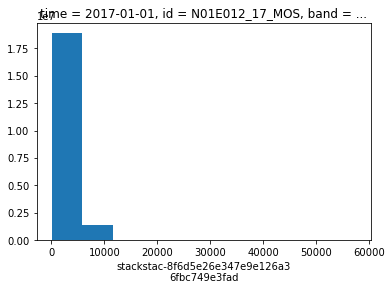

In [29]:
data.squeeze()[1].plot.hist()

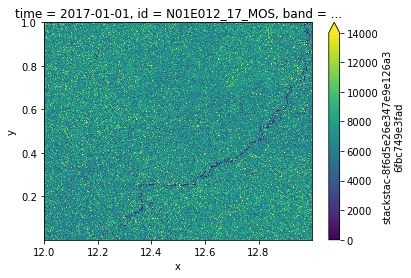

In [28]:
# Plot the HH Polarization
data.squeeze()[0].plot(vmin = 0, vmax = 14000)

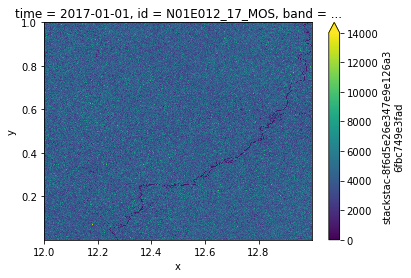

In [31]:
# Plot the HV Polarization
data.squeeze()[1].plot(vmin = 0, vmax = 14000)

## Forest Classification

ALOS Forest/Non-Forest Classification is derived from the ALOS PALSAR Annual Mosaic, and classifies the pixels to detect forest cover.

In [57]:
from pystac_client import Client

tonga = [-176.2142959,  -22.3487289, -173.7369656,  -15.5661351]
client = Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/", #Todo: staging api for now
    ignore_conformance=True,
)
search = client.search(
    collections=["alos-fnf-mosaic"],
    #intersects={"type": "Point", "coordinates": tonga},
)
fnf_items = list(search.get_items())
print(f"Returned {len(items)} items")

Returned 500 items


In [58]:
fnf_item = fnf_items[10]
fnf_item.assets

{'C': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_fnf_mosaic/N01E013_17_C_F02DAR.tif>,
 'tilejson': <Asset href=https://pct-apis-staging.westeurope.cloudapp.azure.com/data/item/tilejson.json?collection=alos-fnf-mosaic&item=N01E013_17_FNF&assets=C&>,
 'rendered_preview': <Asset href=https://pct-apis-staging.westeurope.cloudapp.azure.com/data/item/preview.png?collection=alos-fnf-mosaic&item=N01E013_17_FNF&assets=C&>}

In [59]:
fnf_signed_asset = planetary_computer.sign(fnf_item.assets["C"])
fnf_tile = (
    xarray.open_dataset(fnf_signed_asset.href, engine = "rasterio")
    .squeeze()
    .drop("band")
)
fnf_tile

<xarray.Dataset>
Dimensions:      (x: 4500, y: 4500)
Coordinates:
  * x            (x) float64 13.0 13.0 13.0 13.0 13.0 ... 14.0 14.0 14.0 14.0
  * y            (y) float64 0.9999 0.9997 0.9994 ... 0.0003333 0.0001111
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

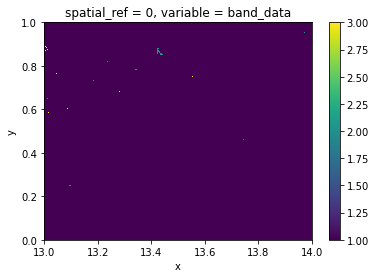

In [63]:
fnf_tile.to_array().plot()